# Eye-Blink Detection
This notebook is an exploratory analysis of some preliminary data for the 2021-2022 blink-controlled car project (clever name pending). This is our testing space for trying out different analysis approaches.

## Preliminary Data
The following uses data on normal and driving-type blinks recorded on November 11 2021, by Matthew Blacker, Michael Kim, and Alex Pleava, from Matthew Blacker.
The data consists of three files:
1. **Blinks_60s_BlinkEvery5s.csv**: Data on normal blinks, roughly every 5 seconds for 60 seconds (minus stream initiation time)
2. **DrivingBlinksLeftEye_120s_BlinkEvery10sFor2s.csv**: Data on left-eye driving blinks, roughly every 10 seconds for 120 seconds (minus stream initiation time).
3. **DrivingBlinksRightEye_120s_BlinkEvery10sFor2s.csv**: Data on right-eye driving blinks, roughly every 10 seconds for 120 seconds (minus stream initiation time).

Our goals for the analysis are:
1. Detect normal eyeblinks
2. Detect normal eyeblinks from only the first 0.5 seconds of a blink
3. Separate normal eyeblinks from driving eye blinks
4. Detect which eye the eyeblinks are coming from

### Dataset Description

The following is a description of the recordings that are tested throughout this notebook.

- **Matt/Blinks_60s_BlinkEvery5s**: Recorded November 11, 2021 in Thode Basement, on Alex's laptop. The Muse was used without any additional hat or headband to hold it in place. Matt blinked once with both eyes every 5 seconds for a minute.

- **Matt/DrivingBlinksLeftEye_120s_BlinkEvery10sFor2s**: Recorded November 11, 2021 in Thode Basement, on Alex's laptop. The Muse was used without any additional hat or headband to hold it in place. Matt forcefully closed his left eye for 2s, then kept it open for 8s. The whole time, he was blinking normally and comfortably with both eyes.

- **Matt/DrivingBlinksLeftEye_120s_BlinkEvery10sFor2s**: Recorded November 11, 2021 in Thode Basement, on Alex's laptop. The Muse was used without any additional hat or headband to hold it in place. Matt forcefully closed his right eye for 2s, then kept it open for 8s. The whole time, he was blinking normally and comfortably with both eyes.

- **Alex/LeftDrivingBlinks_WithHat_ClosedRight_5s**: Recorded November 26, 2021 at Alex's house, on Alex's laptop. The muse was used with a hat to hold it in place. Alex held his right eye closed, and winked his left eye every 5s.

- **Alex/RightDrivingBlinks_WithHat_ClosedLeft_5s**: Recorded November 26, 2021 at Alex's house, on Alex's laptop. The muse was used with a hat to hold it in place. Alex held his left eye closed, and winked his right eye every 5s.

### Loading in the Data and Preparing the Dataset
We want to load in the data and prepare it to be analyzed. To do this, we'll store the actual values in pandas dataframes, which are python data structures that resemble spreadsheets, and are frequently used to store lots of tabular data. These dataframes really store the actual data inside a numpy array.

Once we have the data, we'll want to load it into MNE, by using it to initialize a RawData object in MNE.

Finally, we want to separate the eyeblinks so that we know which stretches of time contain eyeblinks, and which don't. We'll do this in a very crude way for now, just by using a threshold. Any time the signal crosses that threshold, it's labelled as some kind of blink.

In [1]:
# Load in the data as pandas dataframes
import pandas as pd
# Keep a dictionary so we can index each dataset by name
raw_recordings = {"Matt_NormalBlinks": pd.read_csv("Data/Matt/Blinks_60s_BlinkEvery5s.csv"), 
                "Matt_DrivingBlinksLeft": pd.read_csv("Data/Matt/DrivingBlinksLeftEye_120s_BlinkEvery10sFor2s.csv").iloc[:-500], 
                "Matt_DrivingBlinksRight": pd.read_csv("Data/Matt/DrivingBlinksRightEye_120s_BlinkEvery10sFor2s.csv"),
                "Alex_LeftWinkWithHat": pd.read_csv("Data/Alex/LeftDrivingBlinks_WithHat_ClosedRight_5s.csv"), 
                "Alex_RightWinkWithHat": pd.read_csv("Data/Alex/RightDrivingBlinks_WithHat_ClosedLeft_5s.csv")}
# Print the head of the dataframes so we can verify that it imported properly
for key in raw_recordings.keys():
    print(key)
    print(raw_recordings[key].head())

Matt_NormalBlinks
   timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1635968532   3.418  36.621  33.691  24.902     61.035
1  1635968532 -18.066  36.621  32.227  30.273     67.871
2  1635968532  32.227  31.250  31.250  25.879     94.238
3  1635968532  88.867  30.273  31.738  15.137    110.352
4  1635968532  27.832  31.738  35.645  16.602     94.727
Matt_DrivingBlinksLeft
     timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.635970e+09  83.984  25.391  26.367  13.184     48.340
1  1.635970e+09  39.551  20.508  27.832  17.578     52.246
2  1.635970e+09 -17.578  13.184  35.645  17.578     34.180
3  1.635970e+09  -6.348  14.648  30.273  16.602     40.527
4  1.635970e+09  55.176  17.090  15.137  14.648     48.828
Matt_DrivingBlinksRight
     timestamps     TP9     AF7     AF8    TP10  Right AUX
0  1.635969e+09  69.824  39.551  38.086  40.039    104.492
1  1.635969e+09  93.750  35.156  26.367  27.832     18.066
2  1.635969e+09  -5.371  32.227  40.527  27.344     -9.766
3  

Now, we want to label individual eyeblinks. We can try using the fact that eyeblinks tend to have voltages that dip below -50, and typically last about 200 timepoints. Let's see how well that works.

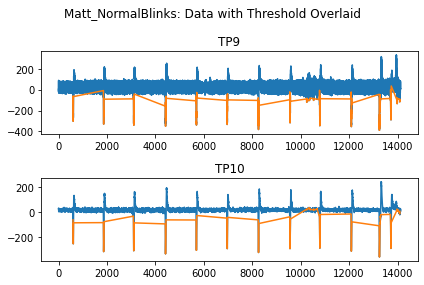

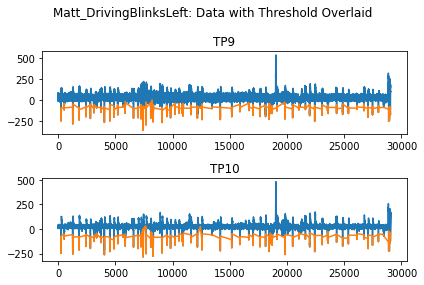

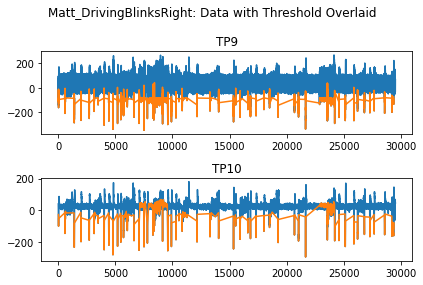

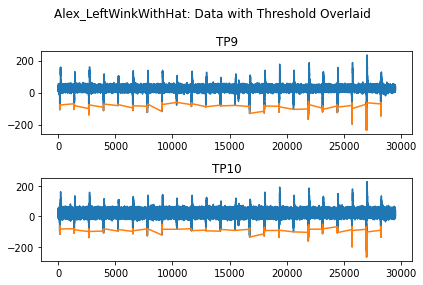

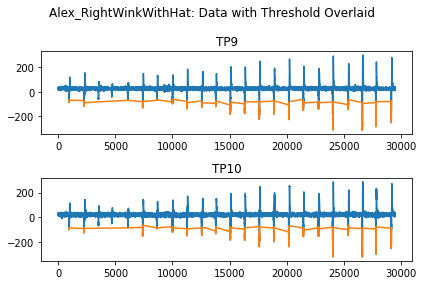

In [2]:
# Import matplotlib.pytplot for plotting
import matplotlib.pyplot as plt
# Import for manipulating arrays
import numpy as np

# The threshold voltage for eyeblinks and the channels where we expect them to be most visible
eyeblink_discrimination_voltage = -80
eyeblink_discrimination_channels = ["TP9", "TP10"]

# For each dataset, locate the eyeblinks
for key, dataset in raw_recordings.items():
    # Get the locations (aka indices aka row numbers) where any one of the eyeblink discrimination channels crosses threshold
    blink_locations = np.where(np.any(dataset[eyeblink_discrimination_channels] < eyeblink_discrimination_voltage, axis=1))
    # Plot the data in the eyeblink discrimination channels, along with where the eyeblink discrimination channels cross threshold
    fig, ax = plt.subplots(len(eyeblink_discrimination_channels))
    for eyeblink_discrimination_channel_idx in range(len(eyeblink_discrimination_channels)):
        eyeblink_discrimination_channel = eyeblink_discrimination_channels[eyeblink_discrimination_channel_idx]
        ax[eyeblink_discrimination_channel_idx].plot(dataset[eyeblink_discrimination_channel])
        ax[eyeblink_discrimination_channel_idx].plot(dataset[eyeblink_discrimination_channel][blink_locations[0]])
        ax[eyeblink_discrimination_channel_idx].set_title(f"{eyeblink_discrimination_channel}")
    fig.suptitle(f"{key}: Data with Threshold Overlaid")
    plt.tight_layout()
    plt.show()

It looks like this method correctly finds (most of) the eyeblinks, shown as the orange high-lighted segments. 

Now, we can use the labelled eyeblinks to assign each time point a label, based on whether or not it's part of a blink. We'l lstore this label in a new column of the data, called "Blink", which will be equal to 0 if it's not part of a blink, and 1 otherwise.

But, the eyeblinks are longer than just the segment that lies below -50. So, we want to expand our selection to be about 50 time points before the first sign of dipping below -50, to about 150 time points after the first sign.

In [3]:
# For each dataset, locate the eyeblinks
for key, dataset in raw_recordings.items():
    # Get the locations where the voltage dips below the discrimination voltage
    blink_locations = np.where(dataset[eyeblink_discrimination_channel] < eyeblink_discrimination_voltage)[0]
    # Create a new array, which is the blink_locations abvoe shifted over by one position
    shifted_blink_positions = np.roll(blink_locations, 1)
    # Subtract the shifted array from the original one; the locations where this is != 1 are where
    # the ranges in the array above are not continuous. ex. [4, 5, 6, 104, 105, 106] - [106, 4, 5, 6, 104, 105] = [-102, 1, 1, 98, 1, 1]
    blink_locations = blink_locations[(blink_locations - shifted_blink_positions) != 1]

    # Create a new column in the dataset which represents whether we currently are in a blink or not
    dataset["Blink"] = np.zeros(dataset["timestamps"].size)
    # On each side of the blink locations, a range from 50 before and 150 after should cover the whole blink
    for blink_location in blink_locations:
        start = blink_location - 30
        stop = blink_location + 170
        if blink_location < 30: start = 0
        if blink_location + 170 > dataset["timestamps"].size: stop = dataset["timestamps"].size
        dataset["Blink"][start:stop] = np.ones(stop - start)

C:\Users\alexp\AppData\Local\Temp/ipykernel_11156/1840054051.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["Blink"][start:stop] = np.ones(stop - start)


Now, we can plot the eyeblinks to see if we labelled the data properly with blinks. If you change the left and right variables below you can scan through the data sets and see if we properly detected eyeblinks throughout.

It looks like we did, so now we can count on the "Blink" column of our dataset to tell us whether a particular time point is during a blink or not.

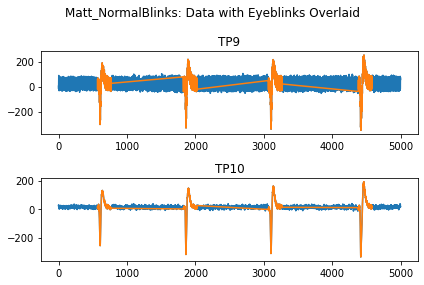

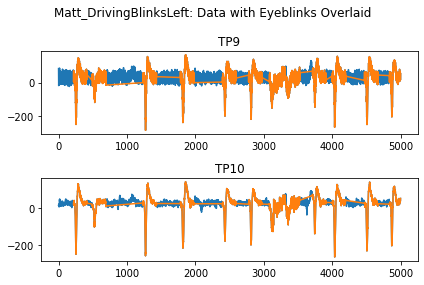

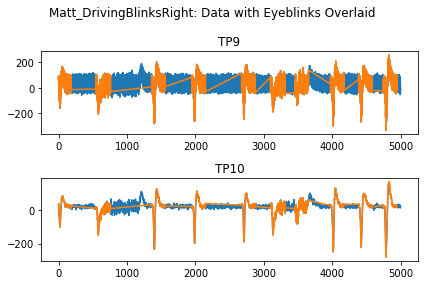

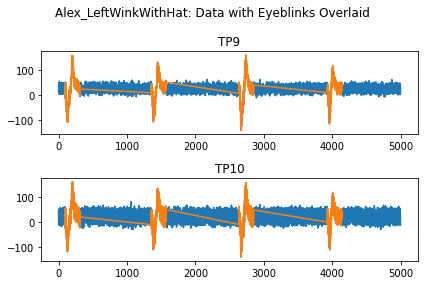

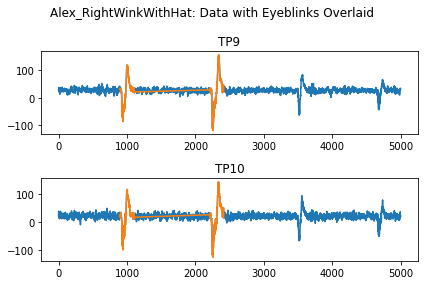

In [4]:
# Set the left and right x-limits of the plot so we can zoom in to specific regions and see if the partitioning is accurate
left = 0
right = 5000
# Plot the data in this region, and colour the detected eyeblinks orange
for key, dataset in raw_recordings.items():
    fig, ax = plt.subplots(len(eyeblink_discrimination_channels))
    for eyeblink_discrimination_channel_idx in range(len(eyeblink_discrimination_channels)):
        eyeblink_discrimination_channel = eyeblink_discrimination_channels[eyeblink_discrimination_channel_idx]
        ax[eyeblink_discrimination_channel_idx].plot(dataset[eyeblink_discrimination_channel][left:right])
        ax[eyeblink_discrimination_channel_idx].plot(dataset[eyeblink_discrimination_channel][left:right][dataset["Blink"] == 1])
        ax[eyeblink_discrimination_channel_idx].set_title(f"{eyeblink_discrimination_channel}")
    fig.suptitle(f"{key}: Data with Eyeblinks Overlaid")
    plt.tight_layout()
    plt.show()

Finally, we are ready to create the MNE objects that we'll use for the rest of the analysis:

In [5]:
# Import MNE
import mne
# Tell MNE to not bother us with outputs unless something's wrong
mne.set_log_level("WARNING")

# Create the info object that stores our metadata
info = mne.create_info(["timestamps","TP9","AF7","AF8", "TP10", "Right AUX", "Blink"], 256, ch_types="eeg")

# Create the MNE raw data object using the raw data (.values.T to extract the values only, and transpose to make it in the format MNE wants)
raw_data = {key : mne.io.RawArray(raw_recordings[key].values.T, info) for key, _ in raw_recordings.items()}

# # Add the Right AUX channel as a reference
# raw_data = {key : raw_array.set_eeg_reference(["Right AUX"], ch_type="eeg") for key, raw_array in raw_data.items()}

# Create the MNE Epochs object using the Blink column
events = {key: mne.find_events(raw_data[key], stim_channel="Blink") for key in raw_recordings}
epoched_data = {key: mne.Epochs(raw_data[key], events[key]) for key in raw_recordings}

# Create the MNE Evoked object using the epochs
evoked_data = {key : epoched.average(picks="all") for key, epoched in epoched_data.items()}

## Checking the Dataset

Let's do some checks to see if the data as a whole contains a reliable blink-signal that we can try to detect. Let's start with the power spectral densities to see if we have any weird signals. 

C:\Users\alexp\AppData\Local\Temp/ipykernel_11156/4019749504.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.plot_psd(picks=["AF7","AF8","TP9","TP10"])


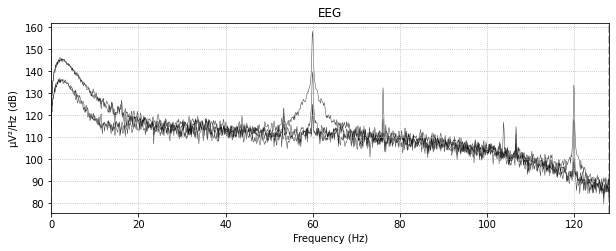

C:\Users\alexp\AppData\Local\Temp/ipykernel_11156/4019749504.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.plot_psd(picks=["AF7","AF8","TP9","TP10"])


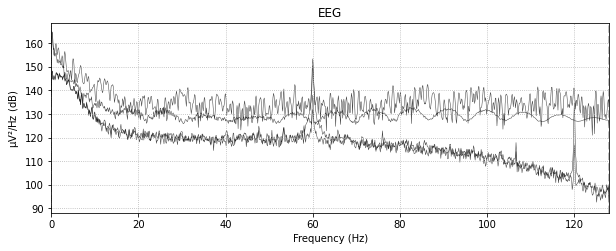

C:\Users\alexp\AppData\Local\Temp/ipykernel_11156/4019749504.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.plot_psd(picks=["AF7","AF8","TP9","TP10"])


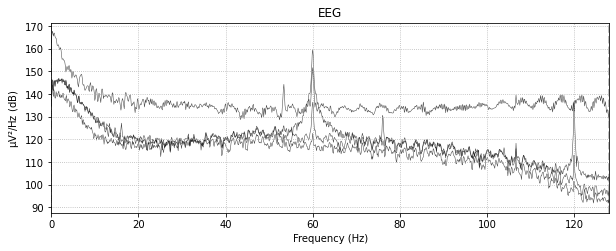

C:\Users\alexp\AppData\Local\Temp/ipykernel_11156/4019749504.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.plot_psd(picks=["AF7","AF8","TP9","TP10"])


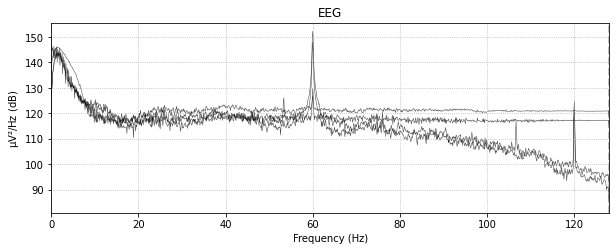

C:\Users\alexp\AppData\Local\Temp/ipykernel_11156/4019749504.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.plot_psd(picks=["AF7","AF8","TP9","TP10"])


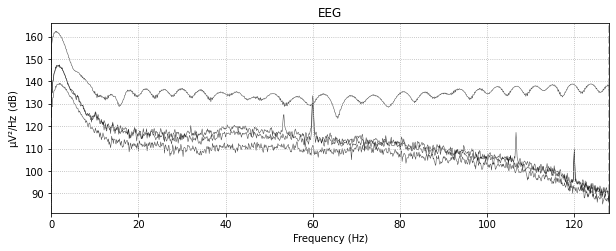

In [6]:
# Plot the PSDs of the data so we can see what the frequency content is like.
for key, data in raw_data.items():
    data.plot_psd(picks=["AF7","AF8","TP9","TP10"])

As expected, some of the datasets (especially Matt's, which were recorded in Thode basement) have some significant 60 Hz signal. Some of this is due to power line noise, but some of it is actual eyeblink signal. The eyeblink signals last about 1s, meaning they have significant 60 Hz contribution, and filtering out the powerline noise would remove them as well.

There are definitely also some strange features to these plots that should be investigated:
- What's causing those waves in the plots?

Lets keep going and visualize the epochs, to see if we can notice any patterns in the averaged-out eyeblinks.

C:\Users\alexp\AppData\Local\Temp/ipykernel_11156/1488015420.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


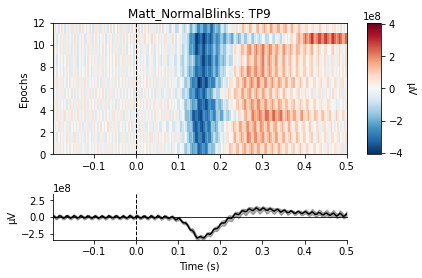

C:\Users\alexp\AppData\Local\Temp/ipykernel_11156/1488015420.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


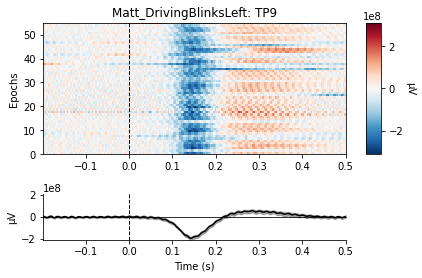

C:\Users\alexp\AppData\Local\Temp/ipykernel_11156/1488015420.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


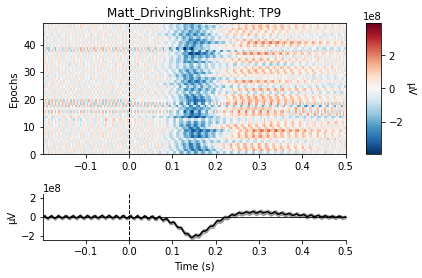

C:\Users\alexp\AppData\Local\Temp/ipykernel_11156/1488015420.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


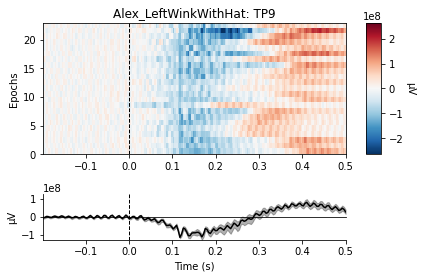

C:\Users\alexp\AppData\Local\Temp/ipykernel_11156/1488015420.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")


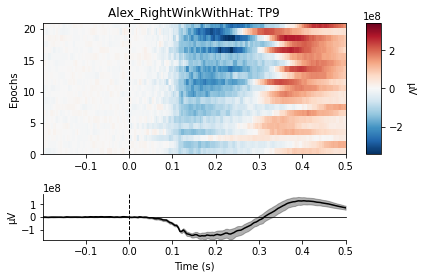

In [7]:
channel_to_plot = "TP9"
for key, dataset in epoched_data.items():
    dataset.plot_image(picks=channel_to_plot, title=f"{key}: {channel_to_plot}")

There is clearly a general trend in the eyeblinks, Since stacking them up like this shows that the dips in the signal (blue) and rises in the signal (red) happen at roughly the same time with each eyeblink. Since they follow similar patterns, this justifies looking at the *average* signal for each of these blink-types.

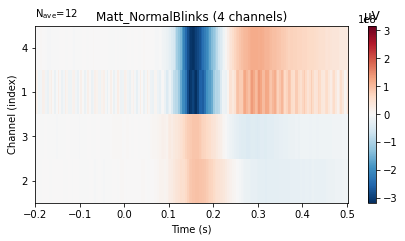

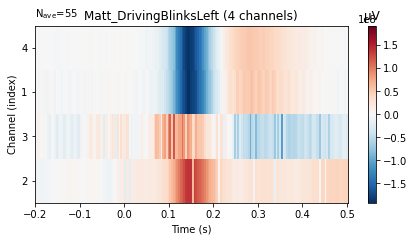

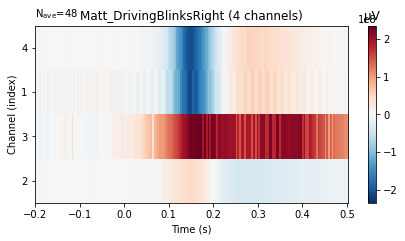

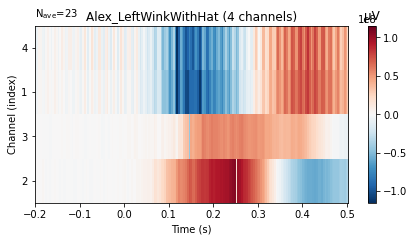

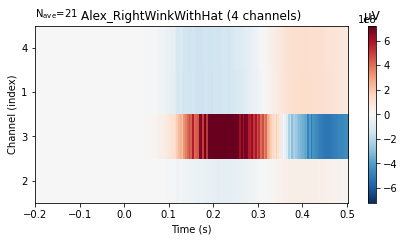

In [8]:
for key, evoked in evoked_data.items():
    evoked.plot_image(picks=["AF7","AF8","TP9","TP10"], titles=key)

These plots show the asymmetry that exists in people's eyeblinks. Despite this, the signals are different, and we should be able to distinguish between left, right, and normal winks. Some approaches to this are tested out below.

## Idea #1: Window Variance

### Explanation of the Idea
We might be able to distinguish between normal and driving blinks using the variance of the signal in a given window. We expect that both normal and driving blinks will lead to large variances on their windows, but driving blinks should have more due to the muscle contractions that are involved with shutting your eye so forcefully. 

### Method
To do this, we need to pick a window size on which to calculate the variance. Since a normal blink takes roughly 200 timesteps, we can use 200 as the window size. For the step length, let's use 1 for now. This will change based on the processing latency when we actually stream data in real-time.

### Results
Below, we find the variance for each window, and plot the variance of a window on the y-axis vs the index of the window's start. Superimposing this variance signal with the eyeblinks shows that it picks up the normal eyeblinks pretty well, but the driving blinks have a messy variance signal.

Also, the hope was that the variance has different peaks between normal and driving blinks. To check this, we plotted a histogram of the peaks in the variance. While the normal blinks have a pretty nicely-distributed peak height, the mix of normal and driving blinks is not as bimodal as we would have hoped. If we see two separate peaks, then we can say that the lower and higher peaks in the distribution of variances correspond to the different kinds of blinks. Unfortunately, we don't see that.

### Future Approach
The fact that this approach doesn't work may be due to the difference in the duration of normal and driving blinks, so on a window that is the size of normal blinks, you'll get good detection of normal blinks but the driving blinks will be split across multiple windows and therefore they won't pop out as much. For windows that are the size of driving blinks, we'll pick up their variance very easily, but normal blinks will get "washed out" since they will only occupy a small fraction of the window.

Matt_NormalBlinks


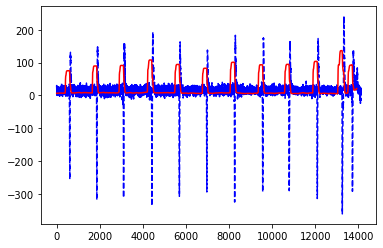

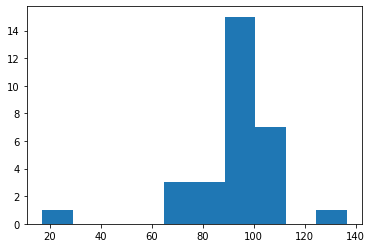

Matt_DrivingBlinksLeft


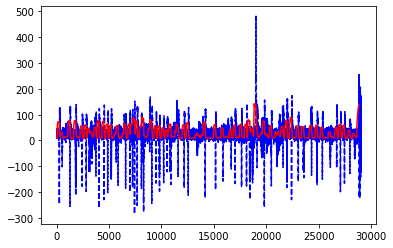

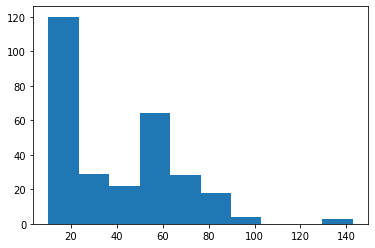

Matt_DrivingBlinksRight


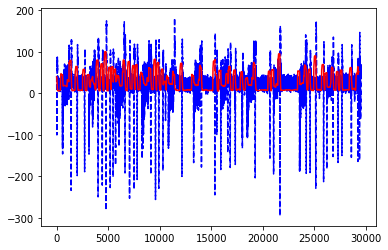

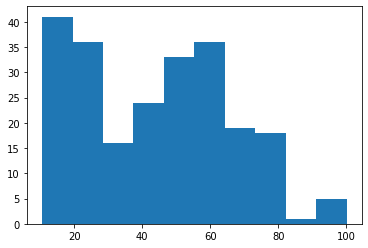

Alex_LeftWinkWithHat


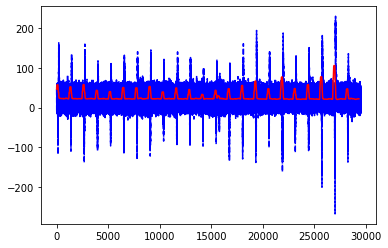

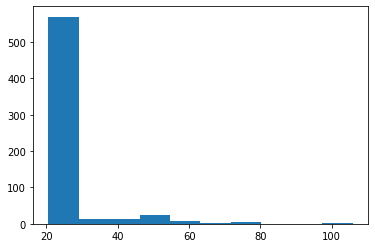

Alex_RightWinkWithHat


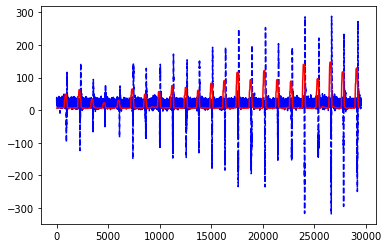

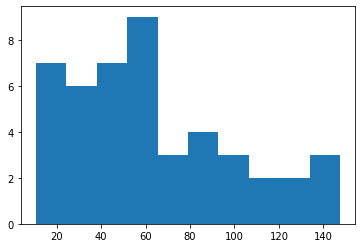

In [10]:
import numpy as np
import scipy.signal as signal
for key, dataset in raw_recordings.items():
    print(key)
    variance_list = []
    for window_start in range(0, dataset["timestamps"].size - 200, 10):
        window_stop = window_start + 200
        channelname = "TP10"
        variance_list.append(np.std(dataset[channelname][window_start:window_stop]))
    #plt.plot(dataset[channelname])
    variance_list = np.array(variance_list)
    non_baseline = variance_list[variance_list > 10]

    plt.plot(dataset[channelname], "--b")
    plt.plot(range(0, dataset["timestamps"].size - 200, 10), variance_list, "r-")

    plt.show()
    plt.hist(non_baseline[signal.argrelextrema(non_baseline, np.greater)[0]])
    plt.show()

## Idea #2: Template-Matching

We can use the average left, right, and normal eye-blink as a "template" for what left, right, and normal blinks look like respectively. If we slide this template along the data, we can take a window that is the size of the template and ask how well the template "fits" to the data in that window. In each window, we can predict which kind of blink (if any) is occurring, based on which template fits the data the best.